# **Please UPVOTE The notebook**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


#### import libraries, and load data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#### **reading the csv file**

In [3]:
df = pd.read_csv("/kaggle/input/titanic/train.csv", index_col="PassengerId")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col="PassengerId")
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


### **starting with Explolatory data analysis (EDA)**

In [4]:
# shape of the training data
df.shape

(891, 11)

In [5]:
# general info about columns of the data in our hand
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
# information about numerical columns
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# number of null values in each column
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
# here the percentage of null values in each column
df.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

## columns that will be dropped
**["Name", "Cabin", "Ticket", "Fare"]**
#### 1- name column as names doesn't carry relevant information, the same for (Ticket and Fare)
#### 2- 77% of Cabin column is null values, so i will delete that column as we cann't impute it accurately

In [9]:
label = "Survived"

In [10]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
df["Age"].unique(), df["Age"].value_counts()

(array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
         4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
         8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
        49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
        16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
        71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
        51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
        45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
        60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
        70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ]),
 24.00    30
 22.00    27
 18.00    26
 28.00    25
 19.00    25
          ..
 55.50     1
 74.00     1
 0.92      1
 70.50     1
 12.00     1
 Name: Age, Length: 88, dtype: int64)

<AxesSubplot:>

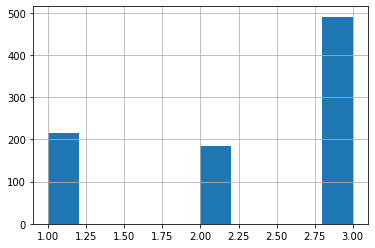

In [12]:
df["Pclass"].hist()

In [13]:
# df.Survived.plot.bar()

<AxesSubplot:>

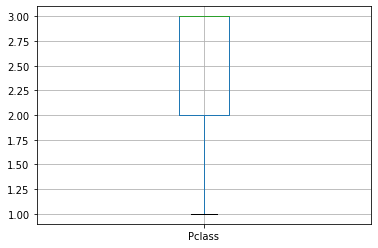

In [14]:
df.boxplot(column="Pclass")

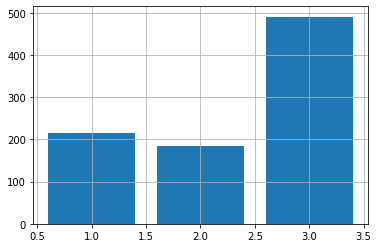

In [15]:
plt.bar(df["Pclass"].value_counts().index, df["Pclass"].value_counts())
plt.grid()

[3 1 2]


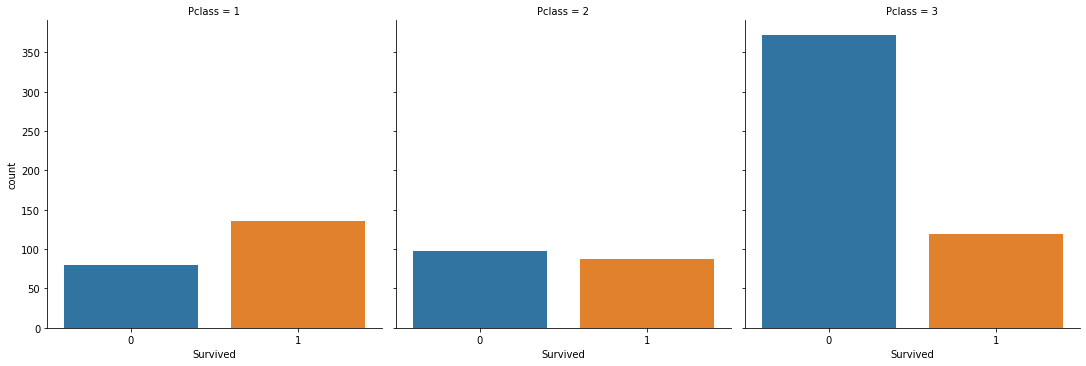

In [16]:
print(df["Pclass"].unique())
sns.catplot(x=label, col="Pclass", kind="count", data=df)

[1 0 3 4 2 5 8]


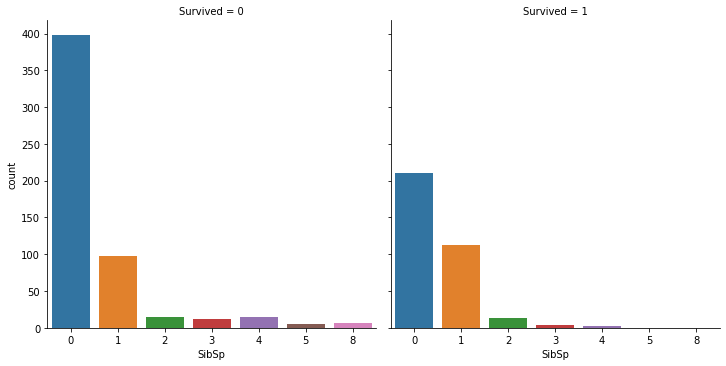

In [17]:
print(df["SibSp"].unique())
sns.catplot(x="SibSp", col=label, kind="count", data=df)
plt.show()

[0 1 2 5 3 4 6]


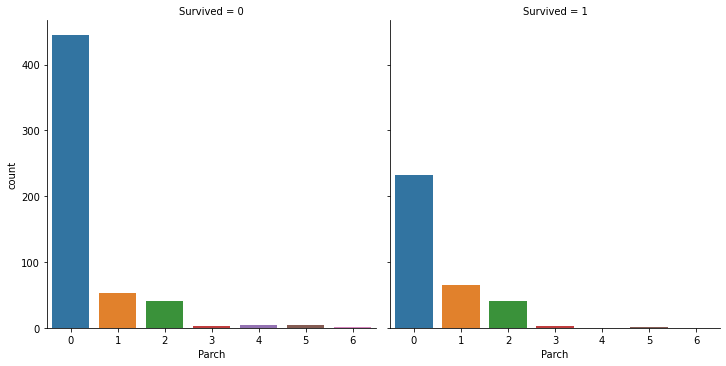

In [18]:
print(df["Parch"].unique())
sns.catplot(x="Parch", col=label, kind="count", data=df)
plt.show()

In [19]:
df["Parch"].nunique(), df["Parch"].value_counts()

(7,
 0    678
 1    118
 2     80
 3      5
 5      5
 4      4
 6      1
 Name: Parch, dtype: int64)

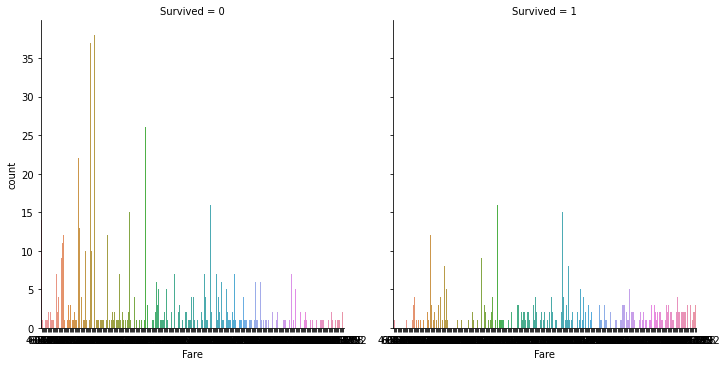

In [20]:
sns.catplot(x="Fare", col=label, kind="count", data=df)

In [21]:
df["Fare"].nunique(), df["Fare"].value_counts()

(248,
 8.0500     43
 13.0000    42
 7.8958     38
 7.7500     34
 26.0000    31
            ..
 50.4958     1
 13.8583     1
 8.4583      1
 7.7250      1
 7.5208      1
 Name: Fare, Length: 248, dtype: int64)

#### Fare column also will be deleted

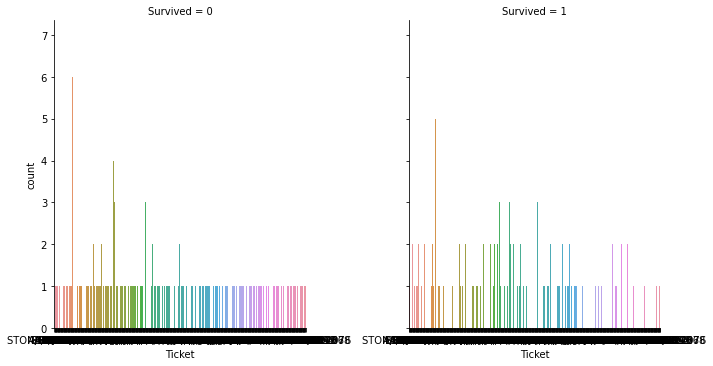

In [22]:
sns.catplot(x="Ticket", col=label, kind='count', data=df);

In [23]:
df["Ticket"].nunique(), df["Ticket"].value_counts()

(681,
 CA. 2343     7
 347082       7
 1601         7
 347088       6
 CA 2144      6
             ..
 A4. 54510    1
 349247       1
 36866        1
 367231       1
 386525       1
 Name: Ticket, Length: 681, dtype: int64)

#### also Ticket column needed to be deleted

### **using train test split function to split the training data into training and validation set**

In [24]:
y = df[label]
x = df.drop(label, axis=1)

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=7, stratify=y)

### *we will do all the preprocessing steps using the make_column_transformer this has many advantages, such as we can involve the preprocessing step in the fine tuning process, and we dont need the repeat the same steps for testing data step by step*

In [25]:
x = df.drop(label, axis=1)
col_trans = make_column_transformer(("drop", ["Name", "Cabin", "Ticket", "Fare"]),
                                    (KNNImputer(), ["Age"]), 
                                    (SimpleImputer(strategy="most_frequent"), ['Embarked']), 
                                    (OneHotEncoder(), ['Sex']),
                                    remainder="passthrough")
col_trans_1 = make_column_transformer( 
                                    (StandardScaler(), [0]),    #Age
                                    (OneHotEncoder(), [1]),    #Embarked
                                     remainder="passthrough")
vt = VarianceThreshold(threshold=0.01)

In [26]:
# clf = RandomForestClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={
#     'randomforestclassifier__n_estimators': range(100, 1500, 100),
#     'randomforestclassifier__criterion' : ["gini", "entropy"],
#     # Number of features to consider at every split
#     "randomforestclassifier__max_features" : ['auto', 'sqrt', 'log2'],
#     # Maximum number of levels in tree
#     "randomforestclassifier__max_depth" : [2,5],
#     # Minimum number of samples requerid to split a node
#     "randomforestclassifier__min_samples_split" : [2,4],
#     # Minimum number of samples requerid at each leaf node
#     "randomforestclassifier__min_samples_leaf" : [1,2],
#     # Method of selecting samples for training each tree
#     "randomforestclassifier__bootstrap" : [True, False]
# }
# search = GridSearchCV(pipe, param_grid, cv=3)

In [27]:
# pipe.get_params().keys()

In [28]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [29]:
# from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [30]:
# from sklearn. import 
# clf = ()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [31]:
from sklearn.svm import SVC
clf = SVC()
pipe = make_pipeline(col_trans,
                     col_trans_1,
                     vt,
                    clf)
param_grid={

}
search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(xtrain, ytrain)
search.best_score_

0.8202783077095726

In [32]:
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [33]:
# from sklearn.ensemble import AdaBoostClassifier
# clf = AdaBoostClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [34]:
# from sklearn.ensemble import ExtraTreesClassifier
# clf = ExtraTreesClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [35]:
# from sklearn.ensemble import BaggingClassifier
# clf = BaggingClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [36]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [37]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [38]:
# from sklearn.tree import ExtraTreeClassifier
# clf = ExtraTreeClassifier()
# pipe = make_pipeline(col_trans,
#                      col_trans_1,
#                      vt,
#                     clf)
# param_grid={

# }
# search = GridSearchCV(pipe, param_grid, cv=5)
# search.fit(xtrain, ytrain)
# search.best_score_

In [39]:
# clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
clf = RandomForestClassifier(max_depth=5, n_estimators=10)
pipe = make_pipeline(col_trans,
                     col_trans_1,
                     vt,
                    clf)
search = GridSearchCV(pipe, {})
search.fit(xtrain, ytrain)
search.best_score_

0.8247559196498709

In [40]:
best_model = search.best_estimator_
best_model.fit(x, y)
pred = best_model.predict(test_data)

index = pd.read_csv("/kaggle/input/titanic/test.csv")["PassengerId"]
my_submission = pd.DataFrame({'PassengerId': index, "Survived": pred})
my_submission.to_csv('submission.csv', index=False)